In [1]:
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
from helpers import subsample_train
from scipy.signal import medfilt
from xgboost import XGBClassifier

from automated_scoring.classification import k_fold_predict
from automated_scoring.classification._optimization_utils import evaluate_results
from automated_scoring.classification.visualization import plot_classification_timeline
from automated_scoring.config import cfg
from automated_scoring.features import DataFrameFeatureExtractor
from automated_scoring.io import load_dataset
from automated_scoring.utils import ensure_generator

from automated_scoring.utils import set_logging_level

In [2]:
cfg.key_keypoints = "keypoints"
cfg.key_timestamp = "timestamps"

cfg.trajectory_keys = (
    "keypoints",
    "timestamps",
)

In [3]:
dataset_train = load_dataset("mice_train", directory="../../datasets/CALMS21/train", target="dyads")
dataset_test = load_dataset("mice_test", directory="../../datasets/CALMS21/test", target="dyads")

2025-02-07 15:56:37.472 | WARNING  | automated_scoring.io:load_dataset:361 - Loading categories (attack, investigation, mount, none) from observations file, specify categories argument if incomplete.
2025-02-07 15:56:38.483 | WARNING  | automated_scoring.io:load_dataset:361 - Loading categories (attack, investigation, mount, none) from observations file, specify categories argument if incomplete.


In [4]:
extractor = DataFrameFeatureExtractor(cache_directory="feature_cache_mice").read_yaml("config_file.yaml")

In [ ]:
# this cell is equivalent to smoothing_experiment-mice.py
# 5-fold cross-validation is performed num_iteration (20) times to average out stochasticity
# these iterations can be performed in parallel on a cluster (using mpi4py) as they don't depend on each other


from automated_scoring.classification.optimize import optimize_smoothing


def smooth(parameters, array):
    return medfilt(array, parameters["median_filter_window"])


set_logging_level("INFO")

best_parameters = optimize_smoothing(
    dataset_train,
    extractor,
    XGBClassifier(n_estimators=100),
    smooth,
    smoothing_parameters_grid={"median_filter_window": np.arange(3, 91, 2)},
    remove_overlapping_predictions=False,
    num_iterations=4,
    k=5,
    exclude=[("intruder", "resident")],
    sampling_func=subsample_train,
    tolerance=0.005,
    random_state=1,
    plot_results=False,
    # results_path=".",
)

2025-02-07 16:00:44.018 [MPI rank 01/01] [INFO    ] [iteration  0] evaluating smoothing
2025-02-07 16:00:44.018 [MPI rank 01/01] [INFO    ] [iteration  0] running 5-fold predict with XGBClassifier
2025-02-07 16:05:20.004 [MPI rank 01/01] [SUCCESS ] [iteration  0] finished 5-fold predict with XGBClassifier
2025-02-07 16:05:20.008 [MPI rank 01/01] [INFO    ] [iteration  0] scoring smoothing parameters


In [6]:
best_parameters  # -> {"median_filter_window": 47}

{'median_filter_window': 43.0}

In [ ]:
# redifine the smoothing function with the optimal parameter

def optimal_smooth(*, array):
    return medfilt(array, 47)  # result from above

In [5]:
# this cell is equivalent to smoothing_experiment-mice.py
# (see comment above)

# from automated_scoring.optimization import optimize_decision_thresholds


# best_thresholds = optimize_decision_thresholds(
#     dataset_train,
#     extractor,
#     XGBClassifier(n_estimators=1000),
#     remove_overlapping_predictions=False,
#     smoothing_func=optimal_smooth,
#     num_iterations=20,
#     k=5,
#     exclude=[("intruder", "resident")],
#     sampling_func=subsample_train,
#     decision_threshold_range=(0.0, 1.0),
#     decision_threshold_step=0.01,
#     tolerance=0.005,
#     random_state=1,
#     plot_results=False,
#     results_path=".",
# )

# best_thresholds  # -> {"attack": 0.3, "investigation": 0.0, "mount": 0.0, "none": 0.0}

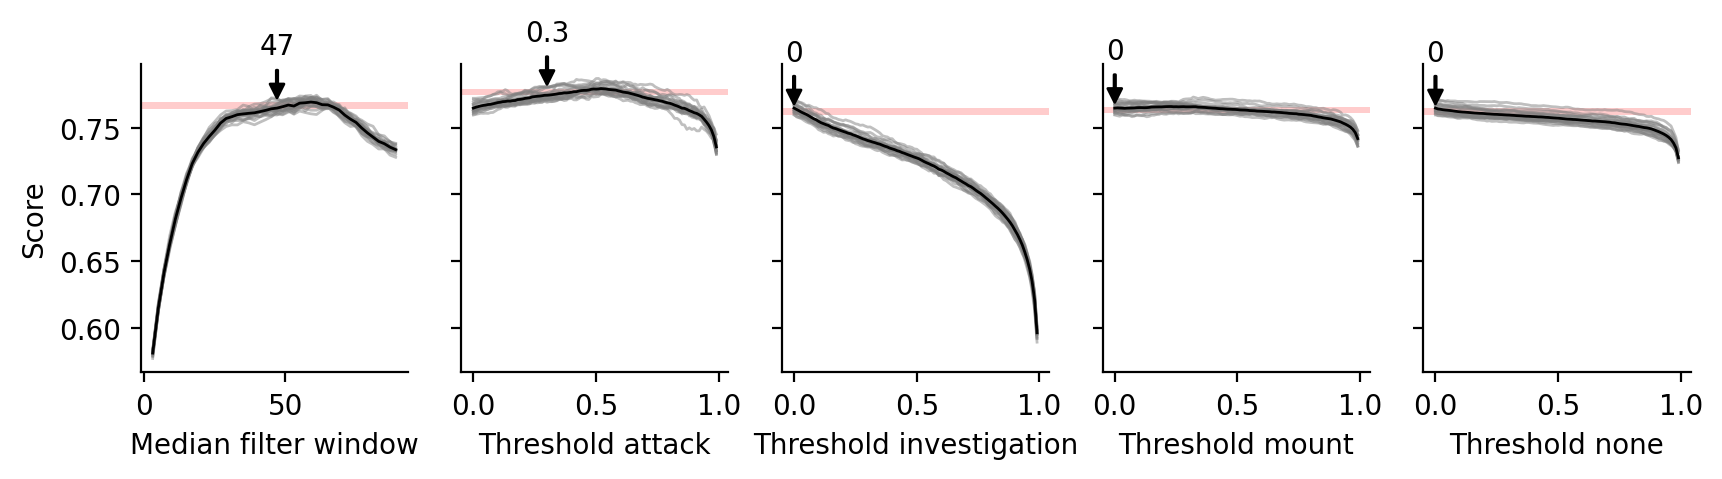

In [9]:
# instead, load results from smoothing_experiment-mice.py and thresholding_experiment-mice.py cluster runs

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(dataset_train.categories) + 1, sharey=True, figsize=(10, 2))

smoothing_results = pd.read_csv("results_smoothing.csv", index_col=0)
evaluate_results(smoothing_results, parameter_names=["median_filter_window"], tolerance=0.005, plot_results=True, axes=axes[[0]])

for category_idx, category in enumerate(dataset_train.categories):
    thresholding_results_category = pd.read_csv(f"results_thresholding-{category}.csv", index_col=0)
    evaluate_results(
        thresholding_results_category,
        parameter_names=[f"threshold_{category}"],
        tolerance=0.005,
        plot_results=True,
        axes=axes[[category_idx + 1]]
    )

for ax in axes[1:]:
    ax.set_ylabel("")

In [7]:
k_fold_result = k_fold_predict(
    dataset_train,
    extractor,
    XGBClassifier(n_estimators=1000, random_state=1),
    k=5,
    exclude=[("intruder", "resident")],
    random_state=ensure_generator(1),
    sampling_func=subsample_train,
    show_progress=True,
).smooth([optimal_smooth], decision_thresholds=[0.3, 0, 0, 0])

k-fold predict:   0%|          | 0/5 [00:00<?, ?it/s]

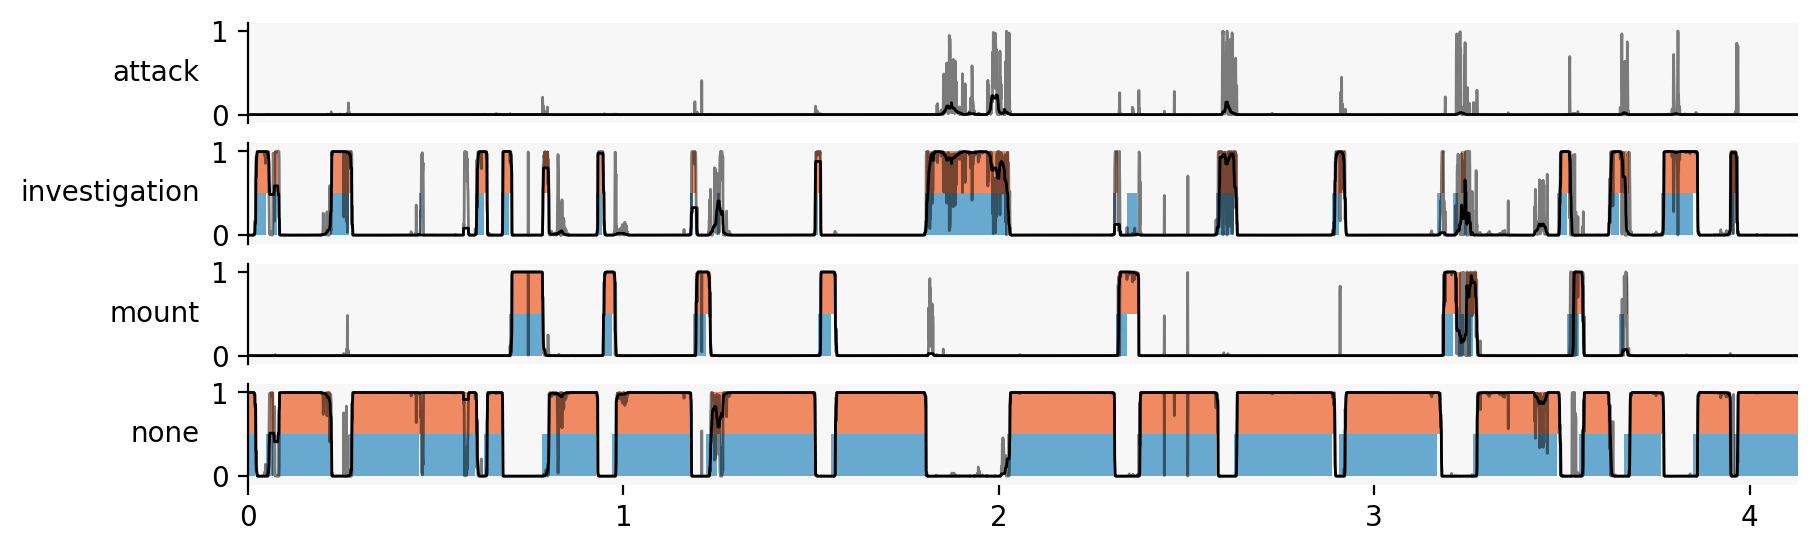

In [15]:
dyad_results = k_fold_result.classification_results[3].classification_results[('resident', 'intruder')]

plot_classification_timeline(
    dyad_results.predictions,
    dyad_results.categories,
    annotations=dyad_results.annotations,
    timestamps=dyad_results.timestamps,
    interval=(-np.inf, np.inf),
    y_proba=dyad_results.y_proba,
    y_proba_smoothed=dyad_results.y_proba_smoothed,
    x_tick_step=(60 * 30),
    x_tick_conversion=lambda ticks: [int(tick / (30 * 60)) for tick in ticks],
)